In [ ]:
import cv2
import numpy as np
import os
import requests
import torch
import torchvision.transforms as T

from PIL import Image


def is_overlapping(rect1, rect2):
    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2
    return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)


def draw_entity_boxes_on_image(image, entities, show=False, save_path=None):
    """_summary_
    Args:
        image (_type_): image or image path
        collect_entity_location (_type_): _description_
    """
    if isinstance(image, Image.Image):
        image_h = image.height
        image_w = image.width
        image = np.array(image)[:, :, [2, 1, 0]]
    elif isinstance(image, str):
        if os.path.exists(image):
            pil_img = Image.open(image).convert("RGB")
            image = np.array(pil_img)[:, :, [2, 1, 0]]
            image_h = pil_img.height
            image_w = pil_img.width
        else:
            raise ValueError(f"invaild image path, {image}")
    elif isinstance(image, torch.Tensor):
        image_tensor = image.cpu()
        reverse_norm_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])[:, None, None]
        reverse_norm_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])[:, None, None]
        image_tensor = image_tensor * reverse_norm_std + reverse_norm_mean
        pil_img = T.ToPILImage()(image_tensor)
        image_h = pil_img.height
        image_w = pil_img.width
        image = np.array(pil_img)[:, :, [2, 1, 0]]
    else:
        raise ValueError(f"invaild image format, {type(image)} for {image}")

    if len(entities) == 0:
        return image

    new_image = image.copy()
    previous_bboxes = []
    # size of text
    text_size = 1
    # thickness of text
    text_line = 1  # int(max(1 * min(image_h, image_w) / 512, 1))
    box_line = 3
    (c_width, text_height), _ = cv2.getTextSize("F", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
    base_height = int(text_height * 0.675)
    text_offset_original = text_height - base_height
    text_spaces = 3

    for entity_name, (start, end), bboxes in entities:
        for (x1_norm, y1_norm, x2_norm, y2_norm) in bboxes:
            orig_x1, orig_y1, orig_x2, orig_y2 = int(x1_norm * image_w), int(y1_norm * image_h), int(x2_norm * image_w), int(y2_norm * image_h)
            # draw bbox
            # random color
            color = tuple(np.random.randint(0, 255, size=3).tolist())
            new_image = cv2.rectangle(new_image, (orig_x1, orig_y1), (orig_x2, orig_y2), color, box_line)

            l_o, r_o = box_line // 2 + box_line % 2, box_line // 2 + box_line % 2 + 1

            x1 = orig_x1 - l_o
            y1 = orig_y1 - l_o

            if y1 < text_height + text_offset_original + 2 * text_spaces:
                y1 = orig_y1 + r_o + text_height + text_offset_original + 2 * text_spaces
                x1 = orig_x1 + r_o

            # add text background
            (text_width, text_height), _ = cv2.getTextSize(f"  {entity_name}", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
            text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2 = x1, y1 - (text_height + text_offset_original + 2 * text_spaces), x1 + text_width, y1

            for prev_bbox in previous_bboxes:
                while is_overlapping((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2), prev_bbox):
                    text_bg_y1 += (text_height + text_offset_original + 2 * text_spaces)
                    text_bg_y2 += (text_height + text_offset_original + 2 * text_spaces)
                    y1 += (text_height + text_offset_original + 2 * text_spaces)

                    if text_bg_y2 >= image_h:
                        text_bg_y1 = max(0, image_h - (text_height + text_offset_original + 2 * text_spaces))
                        text_bg_y2 = image_h
                        y1 = image_h
                        break

            alpha = 0.5
            for i in range(text_bg_y1, text_bg_y2):
                for j in range(text_bg_x1, text_bg_x2):
                    if i < image_h and j < image_w:
                        if j < text_bg_x1 + 1.35 * c_width:
                            # original color
                            bg_color = color
                        else:
                            # white
                            bg_color = [255, 255, 255]
                        new_image[i, j] = (alpha * new_image[i, j] + (1 - alpha) * np.array(bg_color)).astype(np.uint8)

            cv2.putText(
                new_image, f"  {entity_name}", (x1, y1 - text_offset_original - 1 * text_spaces), cv2.FONT_HERSHEY_COMPLEX, text_size, (0, 0, 0), text_line, cv2.LINE_AA
            )
            # previous_locations.append((x1, y1))
            previous_bboxes.append((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2))

    pil_image = Image.fromarray(new_image[:, :, [2, 1, 0]])
    if save_path:
        pil_image.save(save_path)
    if show:
        pil_image.show()

    return new_image

In [ ]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [ ]:
import requests

from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq


model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224")
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")

url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png"
image = Image.open(requests.get(url, stream=True).raw)

def run_example(images, prompt):

    inputs = processor(text=prompt, images=images, return_tensors="pt")
    generated_ids = model.generate(
      pixel_values=inputs["pixel_values"],
      input_ids=inputs["input_ids"],
      attention_mask=inputs["attention_mask"],
      image_embeds=None,
      image_embeds_position_mask=inputs["image_embeds_position_mask"],
      use_cache=True,
      max_new_tokens=128,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    _processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
    processed_text, entities = processor.post_process_generation(generated_text)

    return entities, processed_text, _processed_text
    print(processed_text)
    print(entities)
    print(_processed_text)


In [ ]:



# (The same image from the previous code example)
url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png"
image = Image.open(requests.get(url, stream=True).raw)

# From the previous code example
entities = [('a snowman', (12, 21), [(0.390625, 0.046875, 0.984375, 0.828125)]), ('a fire', (41, 47), [(0.171875, 0.015625, 0.484375, 0.890625)])]

# Draw the bounding bboxes
draw_entity_boxes_on_image(image, entities, show=True)


In [ ]:
prompt = "<grounding> Question: Where is<phrase> the fire</phrase><object><patch_index_0005><patch_index_0911></object> next to? Answer:"
entities, txts, ori_txts = run_example(image, prompt)

# Question: Where is the fire next to? Answer: Near the snowman.
# [('the fire', (19, 27), [(0.171875, 0.015625, 0.484375, 0.890625)]), ('the snowman', (50, 61), [(0.390625, 0.046875, 0.984375, 0.828125)])]

# <grounding> Question: Where is<phrase> the fire</phrase><object><patch_index_0005><patch_index_0911></object> next to? Answer: Near<phrase> the snowman</phrase><object><patch_index_0044><patch_index_0863></object>.


In [ ]:
draw_entity_boxes_on_image(image, entities, show=True)

In [20]:
image = Image.open('/root/autodl-tmp/mmcot_test/n157115.jpg')
q1 = "<grounding><phrase>the black cat</phrase>" 

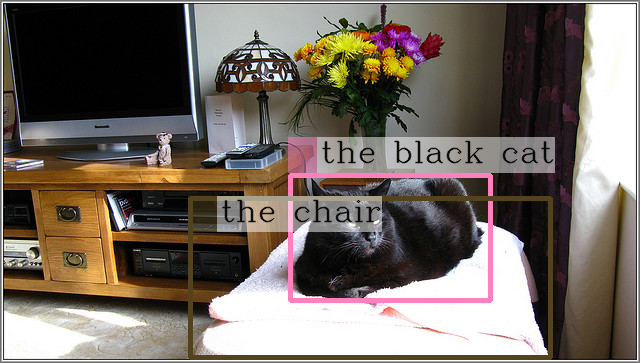

In [22]:
q1_entities, q1_txts, q1_ori_txts = run_example(image, q1)
draw_entity_boxes_on_image(image, q1_entities, show=True)
print()

In [23]:
print(q1_ori_txts)

<grounding><phrase> the black cat</phrase><object><patch_index_0494><patch_index_0856></object> is lying on<phrase> the chair</phrase><object><patch_index_0553><patch_index_1019></object> in the living room


In [36]:
q2= "<grounding> Question:What is directly behind the cat? Answer:"

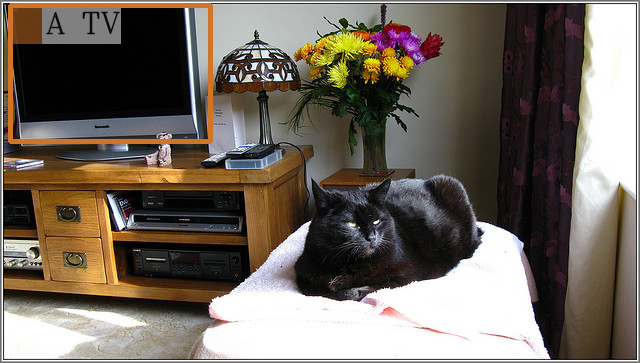

<grounding> Question:What is directly behind the cat? Answer:<phrase> A TV</phrase><object><patch_index_0000><patch_index_0394></object>.


In [37]:
q2_entities, q2_txts, q2_ori_txts = run_example(image, q2)
draw_entity_boxes_on_image(image, q2_entities, show=True)
print(q2_ori_txts)